# Project Storm – Exploratory Data Analysis (EDA)

This notebook runs comprehensive data checks on the cleaned datasets:

- **CAL FIRE Wildfires**
- **NOAA HURDAT**
- **NOAA StormEvents**

We'll log and store important findings so we can reference them in our project or paste them back in here.


In [1]:
import os
import io
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import logging
from datetime import datetime
from IPython.display import display

# Set default plot style
sns.set_theme(style="whitegrid")

# Configure the logger for the notebook
LOG_FILE = "../logs/eda_log.log"

logger = logging.getLogger("EDA_Logger")
logger.setLevel(logging.DEBUG)

# Clear any existing handlers to avoid duplicate logs if rerunning cells.
if logger.handlers:
    logger.handlers = []

# Create a stream handler (for notebook cell output)
sh = logging.StreamHandler()
sh.setLevel(logging.INFO)
sh_formatter = logging.Formatter("[%(asctime)s] [%(levelname)s] %(name)s - %(message)s", datefmt="%Y-%m-%d %H:%M:%S")
sh.setFormatter(sh_formatter)
logger.addHandler(sh)

# Create a file handler (logs to file)
os.makedirs(os.path.dirname(LOG_FILE), exist_ok=True)
fh = logging.FileHandler(LOG_FILE)
fh.setLevel(logging.DEBUG)
fh_formatter = logging.Formatter("%(asctime)s - %(name)s - %(levelname)s - %(message)s")
fh.setFormatter(fh_formatter)
logger.addHandler(fh)

logger.info("\n=== Starting EDA Notebook ===")
logger.info("Notebook initialized and logger configured.")

print("Logger and notebook set up! Logging to:", LOG_FILE)


[2025-04-10 15:45:12] [INFO] EDA_Logger - 
=== Starting EDA Notebook ===
[2025-04-10 15:45:12] [INFO] EDA_Logger - Notebook initialized and logger configured.


Logger and notebook set up! Logging to: ../logs/eda_log.log


## 1. Load Cleaned Data

We will load the cleaned CSV files generated by our pipeline. Adjust the paths if needed.


In [2]:
# Define paths to the cleaned CSV files
WILDFIRES_PATH = "../output/cleaned/california_wildfires_clean.csv"
HURDAT_PATH = "../output/cleaned/noaa_hurdat_clean.csv"
STORMEVENTS_PATH = "../output/cleaned/stormevents_2014_2024_cleaned.csv"

# Function to safely load a CSV and log the process.
def safe_load_csv(path, description):
    logger.info(f"Attempting to load {description} from {path}")
    if not os.path.exists(path):
        logger.warning(f"File not found: {path}. Returning empty DataFrame.")
        return pd.DataFrame()
    try:
        temp_df = pd.read_csv(path)
        logger.info(f"Loaded {temp_df.shape[0]} rows and {temp_df.shape[1]} columns for {description}.")
        return temp_df
    except Exception as e:
        logger.exception(f"Failed to load {description}.")
        return pd.DataFrame()

# Load the three datasets.
df_wildfires = safe_load_csv(WILDFIRES_PATH, "CAL FIRE Wildfires")
df_hurdat = safe_load_csv(HURDAT_PATH, "NOAA HURDAT")
df_storm = safe_load_csv(STORMEVENTS_PATH, "StormEvents")

logger.info("Finished loading all datasets.")
print("Wildfires shape:", df_wildfires.shape)
print("HURDAT shape:   ", df_hurdat.shape)
print("StormEvents shape:", df_storm.shape)


[2025-04-10 15:45:12] [INFO] EDA_Logger - Attempting to load CAL FIRE Wildfires from ../output/cleaned/california_wildfires_clean.csv
[2025-04-10 15:45:12] [INFO] EDA_Logger - Loaded 2847 rows and 23 columns for CAL FIRE Wildfires.
[2025-04-10 15:45:12] [INFO] EDA_Logger - Attempting to load NOAA HURDAT from ../output/cleaned/noaa_hurdat_clean.csv
[2025-04-10 15:45:12] [INFO] EDA_Logger - Loaded 55230 rows and 10 columns for NOAA HURDAT.
[2025-04-10 15:45:12] [INFO] EDA_Logger - Attempting to load StormEvents from ../output/cleaned/stormevents_2014_2024_cleaned.csv
[2025-04-10 15:45:21] [INFO] EDA_Logger - Loaded 699401 rows and 51 columns for StormEvents.
[2025-04-10 15:45:21] [INFO] EDA_Logger - Finished loading all datasets.


Wildfires shape: (2847, 23)
HURDAT shape:    (55230, 10)
StormEvents shape: (699401, 51)


## 2. Quick Overview and Basic Descriptions

Let's inspect each DataFrame with `.head()`, `.info()`, and `.describe()`.


In [3]:
# Create a dictionary to loop through our datasets.
datasets = {
    "Wildfires": df_wildfires,
    "HURDAT": df_hurdat,
    "StormEvents": df_storm
}

for name, df in datasets.items():
    print(f"\n=== {name} DataFrame: head ===")
    display(df.head(5))
    
    # Capture the .info() output in a string and log it.
    buffer = io.StringIO()
    df.info(buf=buffer)
    info_str = buffer.getvalue()
    
    logger.info(f"\n== {name} .info() ==\n{info_str}")
    print(f"\n=== {name} .info() ===")
    print(info_str)
    
    if not df.empty:
        print(f"\n=== {name} .describe() (including all types) ===")
        display(df.describe(include='all'))
        # Also log numeric summary
        numeric_desc = df.describe()
        logger.info(f"{name} numeric describe:\n{numeric_desc}")



=== Wildfires DataFrame: head ===


,incident_name,incident_is_final,incident_date_last_update,incident_date_created,incident_administrative_unit,incident_administrative_unit_url,incident_county,incident_location,incident_acres_burned,incident_containment,...,incident_latitude,incident_type,incident_id,incident_url,incident_date_extinguished,incident_dateonly_extinguished,incident_dateonly_created,is_active,calfire_incident,notification_desired
0,Bridge Fire,Y,2018-01-09 13:46:00+00:00,2017-10-31 11:22:00+00:00,Shasta-Trinity National Forest,NaN,Shasta,"I-5 and Turntable Bay, 7 miles NE of Shasta Lake",37.0,100.0,...,40.774000,NaN,2ca11d45-8139-4c16-8af0-880d99b21e82,https://www.fire.ca.gov/incidents/2017/10/31/b...,2018-01-09 13:46:00+00:00,2018-01-09,2017-10-31,N,False,False
1,Pala Fire,Y,2020-09-16 14:07:35+00:00,2009-05-24 14:56:00+00:00,CAL FIRE San Diego Unit,NaN,San Diego,"Hwy 76 and Pala Temecula, northwest of Pala",122.0,100.0,...,1.000000,Wildfire,8f61f461-552d-4538-b186-35ab030da416,https://www.fire.ca.gov/incidents/2009/5/24/pa...,2009-05-25 00:00:00+00:00,2009-05-25,2009-05-24,N,True,False
2,River Fire,Y,2022-10-24 11:39:23+00:00,2013-02-24 08:16:00+00:00,CAL FIRE San Bernardino Unit,NaN,Inyo,"south of Narrow Gauge Rd & north of Hwy 136, e...",407.0,100.0,...,36.602575,NaN,094719ba-a47b-4abb-9ec5-a506b2b9fd23,https://www.fire.ca.gov/incidents/2013/2/24/ri...,2013-02-28 20:00:00+00:00,2013-02-28,2013-02-24,N,True,False
3,Fawnskin Fire,Y,2013-04-22 09:00:00+00:00,2013-04-20 17:30:00+00:00,San Bernardino National Forest,NaN,San Bernardino,"west of Delamar Mountain, north of the communi...",30.0,100.0,...,34.288877,NaN,58f89ff8-bd3e-4355-b1c0-8fa05c747d3f,https://www.fire.ca.gov/incidents/2013/4/20/fa...,2013-04-22 09:00:00+00:00,2013-04-22,2013-04-20,N,False,False
4,Gold Fire,Y,2013-05-01 07:00:00+00:00,2013-04-30 12:59:00+00:00,CAL FIRE Madera-Mariposa-Merced Unit,NaN,Madera,Between Road 210 and Road 200 near Fine Gold C...,274.0,100.0,...,37.116295,NaN,357ffc13-bef9-48eb-810f-c5de851972eb,https://www.fire.ca.gov/incidents/2013/4/30/go...,2013-05-01 07:00:00+00:00,2013-05-01,2013-04-30,N,True,False


[2025-04-10 15:45:21] [INFO] EDA_Logger - 
== Wildfires .info() ==
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2847 entries, 0 to 2846
Data columns (total 23 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   incident_name                     2847 non-null   object 
 1   incident_is_final                 2847 non-null   object 
 2   incident_date_last_update         2847 non-null   object 
 3   incident_date_created             2847 non-null   object 
 4   incident_administrative_unit      2787 non-null   object 
 5   incident_administrative_unit_url  0 non-null      float64
 6   incident_county                   2837 non-null   object 
 7   incident_location                 2847 non-null   object 
 8   incident_acres_burned             2794 non-null   float64
 9   incident_containment              2791 non-null   float64
 10  incident_control                  117 non-null    object 
 11  in


=== Wildfires .info() ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2847 entries, 0 to 2846
Data columns (total 23 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   incident_name                     2847 non-null   object 
 1   incident_is_final                 2847 non-null   object 
 2   incident_date_last_update         2847 non-null   object 
 3   incident_date_created             2847 non-null   object 
 4   incident_administrative_unit      2787 non-null   object 
 5   incident_administrative_unit_url  0 non-null      float64
 6   incident_county                   2837 non-null   object 
 7   incident_location                 2847 non-null   object 
 8   incident_acres_burned             2794 non-null   float64
 9   incident_containment              2791 non-null   float64
 10  incident_control                  117 non-null    object 
 11  incident_cooperating_agencies     1662 non

,incident_name,incident_is_final,incident_date_last_update,incident_date_created,incident_administrative_unit,incident_administrative_unit_url,incident_county,incident_location,incident_acres_burned,incident_containment,...,incident_latitude,incident_type,incident_id,incident_url,incident_date_extinguished,incident_dateonly_extinguished,incident_dateonly_created,is_active,calfire_incident,notification_desired
count,2847,2847,2847,2847,2787,0.0,2837,2847,2.794000e+03,2791.000000,...,2847.000000,1613,2847,2847,2217,2217,2847,2847,2847,2847
unique,1887,2,2428,2831,789,NaN,105,2789,NaN,NaN,...,NaN,4,2847,2845,1700,935,1361,1,2,1
top,Creek Fire,Y,2018-01-09 13:46:00+00:00,2013-06-10 00:46:00+00:00,CAL FIRE Santa Clara Unit,NaN,Riverside,Unknown / TBD,NaN,NaN,...,NaN,Wildfire,59f47699-1014-4dc6-9349-7c1372e64221,https://www.fire.ca.gov/incidents/2017/8/2/san...,2018-01-09 13:46:00+00:00,2018-01-09,2024-07-03,N,True,False
freq,23,2822,7,2,109,NaN,294,52,NaN,NaN,...,NaN,1580,1,2,7,404,12,2847,1973,2847
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.254046e+03,99.950914,...,38.933643,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.509720e+04,1.213761,...,102.306758,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000e+00,50.000000,...,-120.258000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.000000e+01,100.000000,...,34.566192,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.250000e+01,100.000000,...,37.097900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.410000e+02,100.000000,...,39.066185,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


[2025-04-10 15:45:21] [INFO] EDA_Logger - Wildfires numeric describe:
       incident_administrative_unit_url  incident_acres_burned  \
count                               0.0           2.794000e+03   
mean                                NaN           4.254046e+03   
std                                 NaN           3.509720e+04   
min                                 NaN           0.000000e+00   
25%                                 NaN           3.000000e+01   
50%                                 NaN           8.250000e+01   
75%                                 NaN           3.410000e+02   
max                                 NaN           1.032648e+06   

       incident_containment  incident_longitude  incident_latitude  
count           2791.000000        2.847000e+03        2847.000000  
mean              99.950914       -4.186002e+05          38.933643  
std                1.213761        2.232899e+07         102.306758  
min               50.000000       -1.191415e+09        -120


=== HURDAT DataFrame: head ===


,storm_id,storm_name,datetime,record_identifier,status,latitude,longitude,max_wind_knots,min_pressure_mb,wind_radii_34kt_ne
0,AL011851,UNNAMED,1851-06-25 00:00:00,NaN,HU,28.0,-94.8,80.0,NaN,NaN
1,AL011851,UNNAMED,1851-06-25 06:00:00,NaN,HU,28.0,-95.4,80.0,NaN,NaN
2,AL011851,UNNAMED,1851-06-25 12:00:00,NaN,HU,28.0,-96.0,80.0,NaN,NaN
3,AL011851,UNNAMED,1851-06-25 18:00:00,NaN,HU,28.1,-96.5,80.0,NaN,NaN
4,AL011851,UNNAMED,1851-06-25 21:00:00,L,HU,28.2,-96.8,80.0,NaN,NaN


[2025-04-10 15:45:21] [INFO] EDA_Logger - 
== HURDAT .info() ==
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55230 entries, 0 to 55229
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   storm_id            55230 non-null  object 
 1   storm_name          55230 non-null  object 
 2   datetime            55230 non-null  object 
 3   record_identifier   1248 non-null   object 
 4   status              55230 non-null  object 
 5   latitude            55230 non-null  float64
 6   longitude           55230 non-null  float64
 7   max_wind_knots      55173 non-null  float64
 8   min_pressure_mb     24284 non-null  float64
 9   wind_radii_34kt_ne  11430 non-null  float64
dtypes: float64(5), object(5)
memory usage: 4.2+ MB




=== HURDAT .info() ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55230 entries, 0 to 55229
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   storm_id            55230 non-null  object 
 1   storm_name          55230 non-null  object 
 2   datetime            55230 non-null  object 
 3   record_identifier   1248 non-null   object 
 4   status              55230 non-null  object 
 5   latitude            55230 non-null  float64
 6   longitude           55230 non-null  float64
 7   max_wind_knots      55173 non-null  float64
 8   min_pressure_mb     24284 non-null  float64
 9   wind_radii_34kt_ne  11430 non-null  float64
dtypes: float64(5), object(5)
memory usage: 4.2+ MB


=== HURDAT .describe() (including all types) ===


,storm_id,storm_name,datetime,record_identifier,status,latitude,longitude,max_wind_knots,min_pressure_mb,wind_radii_34kt_ne
count,55230,55230,55230,1248,55230,55230.000000,55230.000000,55173.000000,24284.000000,11430.000000
unique,1991,322,42204,9,9,NaN,NaN,NaN,NaN,NaN
top,AL031899,UNNAMED,2020-09-17 06:00:00,L,TS,NaN,NaN,NaN,NaN,NaN
freq,133,26883,7,1167,20246,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,27.330867,-64.849765,52.675312,992.310740,83.420822
std,NaN,NaN,NaN,NaN,NaN,10.376420,20.200168,24.593975,19.186238,88.879432
min,NaN,NaN,NaN,NaN,NaN,7.000000,-136.900000,10.000000,882.000000,0.000000
25%,NaN,NaN,NaN,NaN,NaN,19.200000,-80.700000,35.000000,984.000000,0.000000
50%,NaN,NaN,NaN,NaN,NaN,26.700000,-67.100000,45.000000,999.000000,70.000000
75%,NaN,NaN,NaN,NaN,NaN,33.600000,-51.100000,70.000000,1006.000000,130.000000


[2025-04-10 15:45:21] [INFO] EDA_Logger - HURDAT numeric describe:
           latitude     longitude  max_wind_knots  min_pressure_mb  \
count  55230.000000  55230.000000    55173.000000     24284.000000   
mean      27.330867    -64.849765       52.675312       992.310740   
std       10.376420     20.200168       24.593975        19.186238   
min        7.000000   -136.900000       10.000000       882.000000   
25%       19.200000    -80.700000       35.000000       984.000000   
50%       26.700000    -67.100000       45.000000       999.000000   
75%       33.600000    -51.100000       70.000000      1006.000000   
max       83.000000     63.000000      165.000000      1024.000000   

       wind_radii_34kt_ne  
count        11430.000000  
mean            83.420822  
std             88.879432  
min              0.000000  
25%              0.000000  
50%             70.000000  
75%            130.000000  
max            780.000000  



=== StormEvents DataFrame: head ===


,BEGIN_YEARMONTH,BEGIN_DAY,BEGIN_TIME,END_YEARMONTH,END_DAY,END_TIME,EPISODE_ID,EVENT_ID,STATE,STATE_FIPS,...,END_RANGE,END_AZIMUTH,END_LOCATION,BEGIN_LAT,BEGIN_LON,END_LAT,END_LON,EPISODE_NARRATIVE,EVENT_NARRATIVE,DATA_SOURCE
0,201402,18,1000,201402,18,2000,83473,503953,NEW HAMPSHIRE,33,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Low pressure developing south of Long Island a...,Eight to twelve inches of snow fell across eas...,CSV
1,201402,5,300,201402,5,2300,83491,504065,NEW HAMPSHIRE,33,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Low pressure moving off the mid-Atlantic coast...,Six to twelve inches of snow fell across easte...,CSV
2,201401,18,1000,201401,19,700,82185,494521,NEW HAMPSHIRE,33,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Low pressure brought a brief period of heavy s...,Four to eight inches of snow fell across easte...,CSV
3,201411,26,1000,201411,27,1000,91728,549746,NEW HAMPSHIRE,33,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A strong coastal storm moved up the east coast...,Six to eight inches of snow fell across easter...,CSV
4,201402,13,630,201402,14,800,83476,503982,NEW HAMPSHIRE,33,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A significant winter storm brought six to twel...,Five to eight inches of snow fell across easte...,CSV


[2025-04-10 15:45:22] [INFO] EDA_Logger - 
== StormEvents .info() ==
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 699401 entries, 0 to 699400
Data columns (total 51 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   BEGIN_YEARMONTH     699401 non-null  int64  
 1   BEGIN_DAY           699401 non-null  int64  
 2   BEGIN_TIME          699401 non-null  int64  
 3   END_YEARMONTH       699401 non-null  int64  
 4   END_DAY             699401 non-null  int64  
 5   END_TIME            699401 non-null  int64  
 6   EPISODE_ID          699401 non-null  int64  
 7   EVENT_ID            699401 non-null  int64  
 8   STATE               699401 non-null  object 
 9   STATE_FIPS          699401 non-null  int64  
 10  YEAR                699401 non-null  int64  
 11  MONTH_NAME          699401 non-null  object 
 12  EVENT_TYPE          699401 non-null  object 
 13  CZ_TYPE             699401 non-null  object 
 14  CZ_FIPS        


=== StormEvents .info() ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 699401 entries, 0 to 699400
Data columns (total 51 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   BEGIN_YEARMONTH     699401 non-null  int64  
 1   BEGIN_DAY           699401 non-null  int64  
 2   BEGIN_TIME          699401 non-null  int64  
 3   END_YEARMONTH       699401 non-null  int64  
 4   END_DAY             699401 non-null  int64  
 5   END_TIME            699401 non-null  int64  
 6   EPISODE_ID          699401 non-null  int64  
 7   EVENT_ID            699401 non-null  int64  
 8   STATE               699401 non-null  object 
 9   STATE_FIPS          699401 non-null  int64  
 10  YEAR                699401 non-null  int64  
 11  MONTH_NAME          699401 non-null  object 
 12  EVENT_TYPE          699401 non-null  object 
 13  CZ_TYPE             699401 non-null  object 
 14  CZ_FIPS             699401 non-null  int64  
 15  CZ_NA

,BEGIN_YEARMONTH,BEGIN_DAY,BEGIN_TIME,END_YEARMONTH,END_DAY,END_TIME,EPISODE_ID,EVENT_ID,STATE,STATE_FIPS,...,END_RANGE,END_AZIMUTH,END_LOCATION,BEGIN_LAT,BEGIN_LON,END_LAT,END_LON,EPISODE_NARRATIVE,EVENT_NARRATIVE,DATA_SOURCE
count,699401.000000,699401.000000,699401.000000,699401.000000,699401.000000,699401.000000,699401.000000,6.994010e+05,699401,699401.000000,...,427748.000000,427748,427748,427748.000000,427748.000000,427748.000000,427748.000000,699401,553875,699401
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,69,NaN,...,NaN,16,43916,NaN,NaN,NaN,NaN,98664,474251,1
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TEXAS,NaN,...,NaN,N,PLAYALINDA BEACH,NaN,NaN,NaN,NaN,An expansive ridge sat over the southern porti...,Heat index values reached or exceeded 105 degr...,CSV
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,52520,NaN,...,NaN,79595,675,NaN,NaN,NaN,NaN,885,589,699401
mean,201930.813316,14.897499,1261.463844,201930.813316,16.531449,1459.353786,141382.247100,8.565753e+05,NaN,33.094427,...,2.468444,NaN,NaN,37.675341,-90.187336,37.673951,-90.181168,NaN,NaN,NaN
std,317.942774,9.080311,676.825816,317.942774,9.093401,614.555231,34025.236949,2.128541e+05,NaN,19.258072,...,4.578676,NaN,NaN,5.193427,11.809369,5.194800,11.806995,NaN,NaN,NaN
min,201401.000000,1.000000,0.000000,201401.000000,1.000000,0.000000,80464.000000,4.819030e+05,NaN,1.000000,...,0.000000,NaN,NaN,-14.400000,-171.032700,-14.437500,-170.905900,NaN,NaN,NaN
25%,201701.000000,7.000000,748.000000,201701.000000,9.000000,1100.000000,112506.000000,6.720490e+05,NaN,19.000000,...,1.000000,NaN,NaN,34.350000,-97.270000,34.350000,-97.260000,NaN,NaN,NaN
50%,201909.000000,15.000000,1431.000000,201909.000000,16.000000,1600.000000,142510.000000,8.565920e+05,NaN,31.000000,...,1.000000,NaN,NaN,38.187100,-89.460000,38.184300,-89.439350,NaN,NaN,NaN
75%,202207.000000,23.000000,1800.000000,202207.000000,25.000000,1900.000000,171271.000000,1.040896e+06,NaN,46.000000,...,3.000000,NaN,NaN,41.253125,-81.390000,41.252500,-81.390000,NaN,NaN,NaN


[2025-04-10 15:45:27] [INFO] EDA_Logger - StormEvents numeric describe:
       BEGIN_YEARMONTH      BEGIN_DAY     BEGIN_TIME  END_YEARMONTH  \
count    699401.000000  699401.000000  699401.000000  699401.000000   
mean     201930.813316      14.897499    1261.463844  201930.813316   
std         317.942774       9.080311     676.825816     317.942774   
min      201401.000000       1.000000       0.000000  201401.000000   
25%      201701.000000       7.000000     748.000000  201701.000000   
50%      201909.000000      15.000000    1431.000000  201909.000000   
75%      202207.000000      23.000000    1800.000000  202207.000000   
max      202412.000000      31.000000    2359.000000  202412.000000   

             END_DAY       END_TIME     EPISODE_ID      EVENT_ID  \
count  699401.000000  699401.000000  699401.000000  6.994010e+05   
mean       16.531449    1459.353786  141382.247100  8.565753e+05   
std         9.093401     614.555231   34025.236949  2.128541e+05   
min         1.00

## 3. Missing Values Analysis

We will calculate and log the percentage of missing values in each column so we can verify data quality and identify issues.


In [4]:
for name, df in datasets.items():
    print(f"\n=== Missing Value Analysis for {name} ===")
    if df.empty:
        print("DataFrame is empty, skipping.")
        continue

    # Calculate the percentage of missing values for each column.
    missing_pct = df.isna().mean() * 100
    missing_pct = missing_pct.sort_values(ascending=False)
    print(missing_pct)
    
    # Log the top 10 columns with the most missing data.
    top_missing = missing_pct.head(10)
    logger.info(f"Top 10 missing columns in {name}:\n{top_missing}")
    
    # Optionally: Save the missing value percentages for further inspection.
    outpath = f"../output/debug/missing_values_{name.lower()}.csv"
    os.makedirs(os.path.dirname(outpath), exist_ok=True)
    missing_pct.to_csv(outpath, header=["pct_missing"])


[2025-04-10 15:45:27] [INFO] EDA_Logger - Top 10 missing columns in Wildfires:
incident_administrative_unit_url    100.000000
incident_control                     95.890411
incident_type                        43.343871
incident_cooperating_agencies        41.622761
incident_dateonly_extinguished       22.128556
incident_date_extinguished           22.128556
incident_administrative_unit          2.107482
incident_containment                  1.966983
incident_acres_burned                 1.861609
incident_county                       0.351247
dtype: float64
[2025-04-10 15:45:27] [INFO] EDA_Logger - Top 10 missing columns in HURDAT:
record_identifier     97.740359
wind_radii_34kt_ne    79.304726
min_pressure_mb       56.031142
max_wind_knots         0.103205
storm_name             0.000000
storm_id               0.000000
latitude               0.000000
status                 0.000000
datetime               0.000000
longitude              0.000000
dtype: float64



=== Missing Value Analysis for Wildfires ===
incident_administrative_unit_url    100.000000
incident_control                     95.890411
incident_type                        43.343871
incident_cooperating_agencies        41.622761
incident_dateonly_extinguished       22.128556
incident_date_extinguished           22.128556
incident_administrative_unit          2.107482
incident_containment                  1.966983
incident_acres_burned                 1.861609
incident_county                       0.351247
incident_date_last_update             0.000000
incident_date_created                 0.000000
incident_name                         0.000000
incident_is_final                     0.000000
incident_location                     0.000000
incident_latitude                     0.000000
incident_longitude                    0.000000
incident_url                          0.000000
incident_id                           0.000000
incident_dateonly_created             0.000000
is_active     

[2025-04-10 15:45:27] [INFO] EDA_Logger - Top 10 missing columns in StormEvents:
CATEGORY              99.944667
TOR_OTHER_WFO         99.700172
TOR_OTHER_CZ_FIPS     99.700172
TOR_OTHER_CZ_STATE    99.700172
TOR_OTHER_CZ_NAME     99.700172
TOR_WIDTH             97.719906
TOR_LENGTH            97.719906
TOR_F_SCALE           97.719906
FLOOD_CAUSE           89.157007
MAGNITUDE_TYPE        62.128593
dtype: float64


CATEGORY              99.944667
TOR_OTHER_WFO         99.700172
TOR_OTHER_CZ_FIPS     99.700172
TOR_OTHER_CZ_STATE    99.700172
TOR_OTHER_CZ_NAME     99.700172
TOR_WIDTH             97.719906
TOR_LENGTH            97.719906
TOR_F_SCALE           97.719906
FLOOD_CAUSE           89.157007
MAGNITUDE_TYPE        62.128593
MAGNITUDE             48.088436
BEGIN_AZIMUTH         38.840808
BEGIN_LOCATION        38.840808
END_RANGE             38.840808
BEGIN_RANGE           38.840808
END_AZIMUTH           38.840808
BEGIN_LON             38.840808
BEGIN_LAT             38.840808
END_LOCATION          38.840808
END_LON               38.840808
END_LAT               38.840808
EVENT_NARRATIVE       20.807234
DAMAGE_PROPERTY       20.438775
DAMAGE_CROPS          20.181698
CZ_TIMEZONE            0.000000
WFO                    0.000000
BEGIN_DATE_TIME        0.000000
YEAR                   0.000000
STATE_FIPS             0.000000
STATE                  0.000000
EVENT_ID               0.000000
EPISODE_

## 4. Basic Distribution Checks

Let's plot histograms for selected numeric columns to understand the distribution of key variables.
- **Wildfires**: `incident_acres_burned`
- **HURDAT**: `max_wind_knots`, `min_pressure_mb`
- **StormEvents**: `BEGIN_LAT`, `BEGIN_LON` (and add others as needed)


[2025-04-10 15:45:27] [INFO] EDA_Logger - Plotting histograms for Wildfires...


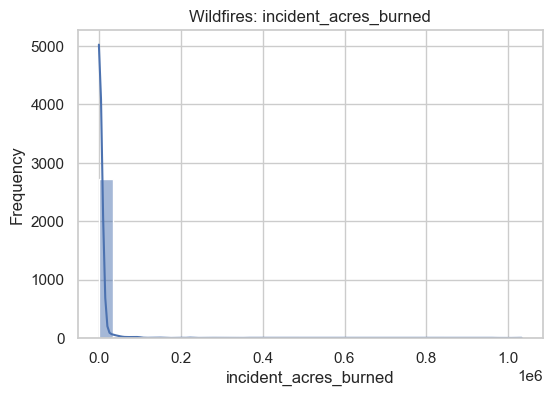

[2025-04-10 15:45:28] [INFO] EDA_Logger - Plotting histograms for HURDAT...


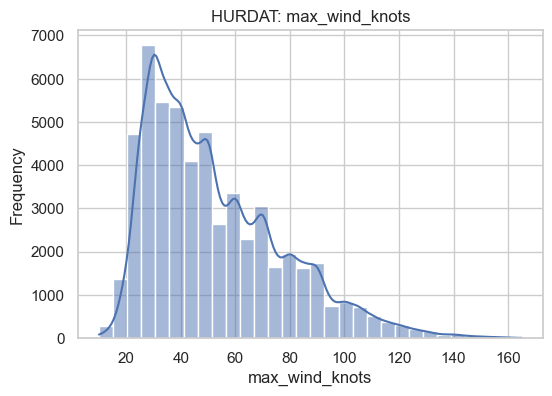

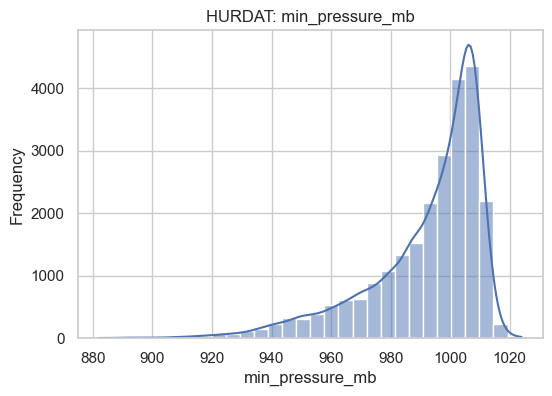

[2025-04-10 15:45:29] [INFO] EDA_Logger - Plotting histograms for StormEvents...


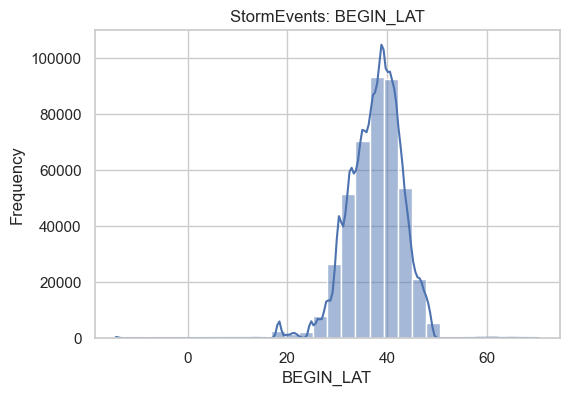

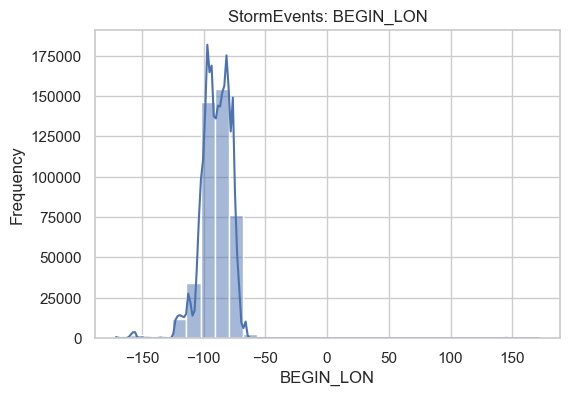

In [5]:
# Utility function to plot histograms for given columns.
def plot_histograms(df, cols, title_prefix="Histogram"):
    for col in cols:
        if col not in df.columns:
            logger.warning(f"Column '{col}' not in DataFrame; skipping histogram.")
            continue
        plt.figure(figsize=(6,4))
        sns.histplot(data=df, x=col, kde=True, bins=30)
        plt.title(f"{title_prefix}: {col}")
        plt.xlabel(col)
        plt.ylabel("Frequency")
        plt.show()

# Plot histograms for each dataset.
if not df_wildfires.empty:
    logger.info("Plotting histograms for Wildfires...")
    plot_histograms(df_wildfires, cols=["incident_acres_burned"], title_prefix="Wildfires")

if not df_hurdat.empty:
    logger.info("Plotting histograms for HURDAT...")
    plot_histograms(df_hurdat, cols=["max_wind_knots", "min_pressure_mb"], title_prefix="HURDAT")

if not df_storm.empty:
    logger.info("Plotting histograms for StormEvents...")
    # If you have additional relevant numeric columns (e.g., magnitude) add them here.
    plot_histograms(df_storm, cols=["BEGIN_LAT", "BEGIN_LON"], title_prefix="StormEvents")
else:
    logger.warning("StormEvents DataFrame is empty; skipping histogram plots.")


## 5. Outlier Analysis

We will use an Interquartile Range (IQR) based method to identify outliers in selected numeric columns.
This helps highlight potential data anomalies that might require further investigation.


In [6]:
# Function to return outliers based on the IQR for a specified column.
def iqr_outliers(df, col, factor=1.5):
    if col not in df.columns:
        logger.warning(f"Column '{col}' not found in DataFrame.")
        return pd.DataFrame()
    
    df_valid = df[df[col].notna()]
    Q1 = df_valid[col].quantile(0.25)
    Q3 = df_valid[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - factor * IQR
    upper_bound = Q3 + factor * IQR
    return df_valid[(df_valid[col] < lower_bound) | (df_valid[col] > upper_bound)]

# Function to print and log a summary of outliers for a given column.
def outlier_summary(df, col, df_name):
    outliers_df = iqr_outliers(df, col)
    if not outliers_df.empty:
        logger.info(f"Outliers found in {df_name}.{col}: {outliers_df.shape[0]} rows.")
        print(f"\n=== Outliers in {df_name}.{col}: {outliers_df.shape[0]} rows ===")
        display(outliers_df.head(3))
    else:
        logger.info(f"No outliers found in {df_name}.{col}.")
        print(f"No outliers found in {df_name}.{col}.")

print("\n=== Outlier Checks ===")
# Wildfires: Check 'incident_acres_burned'
if not df_wildfires.empty and "incident_acres_burned" in df_wildfires.columns:
    outlier_summary(df_wildfires, "incident_acres_burned", "Wildfires")

# HURDAT: Check 'max_wind_knots' and 'min_pressure_mb'
if not df_hurdat.empty:
    if "max_wind_knots" in df_hurdat.columns:
        outlier_summary(df_hurdat, "max_wind_knots", "HURDAT")
    if "min_pressure_mb" in df_hurdat.columns:
        outlier_summary(df_hurdat, "min_pressure_mb", "HURDAT")

# StormEvents: Check 'BEGIN_LAT' and 'BEGIN_LON'
if not df_storm.empty:
    for col in ["BEGIN_LAT", "BEGIN_LON"]:
        if col in df_storm.columns:
            outlier_summary(df_storm, col, "StormEvents")


[2025-04-10 15:45:35] [INFO] EDA_Logger - Outliers found in Wildfires.incident_acres_burned: 479 rows.



=== Outlier Checks ===

=== Outliers in Wildfires.incident_acres_burned: 479 rows ===


,incident_name,incident_is_final,incident_date_last_update,incident_date_created,incident_administrative_unit,incident_administrative_unit_url,incident_county,incident_location,incident_acres_burned,incident_containment,...,incident_latitude,incident_type,incident_id,incident_url,incident_date_extinguished,incident_dateonly_extinguished,incident_dateonly_created,is_active,calfire_incident,notification_desired
5,Panther Fire,Y,2022-10-24 11:40:03+00:00,2013-05-01 09:12:00+00:00,CAL FIRE Butte Unit,NaN,Tehama,"140K3 Line, 8 miles northwest of Butte Meadows",6896.0,100.0,...,40.190062,NaN,53122f0f-fefc-4dbf-b2d8-566b42ced66d,https://www.fire.ca.gov/incidents/2013/5/1/pan...,2013-05-09 09:00:00+00:00,2013-05-09,2013-05-01,N,True,False
8,Summit Fire,Y,2022-10-24 11:40:42+00:00,2013-05-01 12:38:00+00:00,CAL FIRE/Riverside County Fire,NaN,Riverside,Mias Canyon and Bluff Road in Banning,2956.0,100.0,...,34.288877,NaN,a1b14be5-a8cf-4e40-8588-96becf4c5879,https://www.fire.ca.gov/incidents/2013/5/1/sum...,2013-05-04 18:30:00+00:00,2013-05-04,2013-05-01,N,True,False
13,Grand Fire,Y,2013-05-21 19:45:00+00:00,2013-05-15 12:50:00+00:00,CAL FIRE / USFS Los Padres National Forest,NaN,"Kern, Ventura","South of Frazier Mountain Park Rd, South of Fr...",4346.0,100.0,...,34.786100,NaN,e0d038e9-0926-4c05-8317-ec7075a04b12,https://www.fire.ca.gov/incidents/2013/5/15/gr...,2013-05-21 19:45:00+00:00,2013-05-21,2013-05-15,N,True,False


[2025-04-10 15:45:35] [INFO] EDA_Logger - Outliers found in HURDAT.max_wind_knots: 615 rows.



=== Outliers in HURDAT.max_wind_knots: 615 rows ===


,storm_id,storm_name,datetime,record_identifier,status,latitude,longitude,max_wind_knots,min_pressure_mb,wind_radii_34kt_ne
251,AL031853,UNNAMED,1853-09-03 06:00:00,NaN,HU,19.1,-54.6,130.0,NaN,NaN
252,AL031853,UNNAMED,1853-09-03 12:00:00,NaN,HU,19.7,-56.2,130.0,924.0,NaN
253,AL031853,UNNAMED,1853-09-03 18:00:00,NaN,HU,20.7,-58.0,130.0,NaN,NaN


[2025-04-10 15:45:35] [INFO] EDA_Logger - Outliers found in HURDAT.min_pressure_mb: 1180 rows.



=== Outliers in HURDAT.min_pressure_mb: 1180 rows ===


,storm_id,storm_name,datetime,record_identifier,status,latitude,longitude,max_wind_knots,min_pressure_mb,wind_radii_34kt_ne
252,AL031853,UNNAMED,1853-09-03 12:00:00,NaN,HU,19.7,-56.2,130.0,924.0,NaN
346,AL031854,UNNAMED,1854-09-07 12:00:00,NaN,HU,28.0,-78.6,110.0,938.0,NaN
351,AL031854,UNNAMED,1854-09-08 18:00:00,NaN,HU,31.6,-81.1,100.0,950.0,NaN


[2025-04-10 15:45:35] [INFO] EDA_Logger - Outliers found in StormEvents.BEGIN_LAT: 4233 rows.



=== Outliers in StormEvents.BEGIN_LAT: 4233 rows ===


,BEGIN_YEARMONTH,BEGIN_DAY,BEGIN_TIME,END_YEARMONTH,END_DAY,END_TIME,EPISODE_ID,EVENT_ID,STATE,STATE_FIPS,...,END_RANGE,END_AZIMUTH,END_LOCATION,BEGIN_LAT,BEGIN_LON,END_LAT,END_LON,EPISODE_NARRATIVE,EVENT_NARRATIVE,DATA_SOURCE
445,201409,1,1545,201409,1,1842,89537,539231,HAWAII,15,...,0.0,SW,HEEIA,21.5947,-157.9000,21.4250,-157.8248,With a surface trough northwest of the Aloha S...,NaN,CSV
446,201409,10,2010,201409,10,2207,89538,539233,HAWAII,15,...,4.0,SW,WAIKOLOA VILLAGE,20.2200,-155.8823,19.8876,-155.8115,Heavy downpours occurred over portions of Nort...,NaN,CSV
672,201409,2,945,201409,5,15,89575,539390,ALASKA,2,...,20.0,NE,TWO RIVERS,64.8800,-147.3300,65.0400,-146.3600,A weather system moving west over the area bro...,This event is for the Upper Chena River.,CSV


[2025-04-10 15:45:35] [INFO] EDA_Logger - Outliers found in StormEvents.BEGIN_LON: 5236 rows.



=== Outliers in StormEvents.BEGIN_LON: 5236 rows ===


,BEGIN_YEARMONTH,BEGIN_DAY,BEGIN_TIME,END_YEARMONTH,END_DAY,END_TIME,EPISODE_ID,EVENT_ID,STATE,STATE_FIPS,...,END_RANGE,END_AZIMUTH,END_LOCATION,BEGIN_LAT,BEGIN_LON,END_LAT,END_LON,EPISODE_NARRATIVE,EVENT_NARRATIVE,DATA_SOURCE
445,201409,1,1545,201409,1,1842,89537,539231,HAWAII,15,...,0.0,SW,HEEIA,21.5947,-157.9000,21.4250,-157.8248,With a surface trough northwest of the Aloha S...,NaN,CSV
446,201409,10,2010,201409,10,2207,89538,539233,HAWAII,15,...,4.0,SW,WAIKOLOA VILLAGE,20.2200,-155.8823,19.8876,-155.8115,Heavy downpours occurred over portions of Nort...,NaN,CSV
465,201412,20,1915,201412,21,815,91245,546829,WASHINGTON,53,...,1.0,SW,ROSBURG,46.3300,-123.6300,46.3223,-123.6411,A slow moving front produced heavy rain over S...,The Grays River near Rosburg reached the flood...,CSV


## 6. Saving EDA Outputs

We will save summary statistics (i.e., `.describe()` outputs) for each dataset to CSV files in the `output/analysis/` folder for future reference.


In [7]:
os.makedirs("../output/analysis", exist_ok=True)

for name, df in datasets.items():
    if df.empty:
        continue
    desc_all = df.describe(include='all')
    outpath = f"../output/analysis/{name.lower()}_describe.csv"
    desc_all.to_csv(outpath)
    logger.info(f"Saved .describe() for {name} to {outpath}.")

print("EDA summaries saved in ../output/analysis/")
logger.info("=== EDA Notebook finished successfully. ===")


[2025-04-10 15:45:35] [INFO] EDA_Logger - Saved .describe() for Wildfires to ../output/analysis/wildfires_describe.csv.
[2025-04-10 15:45:35] [INFO] EDA_Logger - Saved .describe() for HURDAT to ../output/analysis/hurdat_describe.csv.
[2025-04-10 15:45:42] [INFO] EDA_Logger - Saved .describe() for StormEvents to ../output/analysis/stormevents_describe.csv.
[2025-04-10 15:45:42] [INFO] EDA_Logger - === EDA Notebook finished successfully. ===


EDA summaries saved in ../output/analysis/


## 7. Next Steps

- Review the printed and saved summary statistics, missing value analyses, and outlier reports.
- Identify any data quality issues or necessary transformations.
- Proceed to distribution fitting and scenario modeling using the insights gathered here.
